In [3]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import pprint
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import albumentations as A
import cv2
import wandb

from PIL import Image
from colorama import Fore, Back, Style
# colored output
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA

sns.set(font="Serif",style ="white")

In [20]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb-api-key")

os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'siim-fisabio-rsna-covid-19-detection', '_wandb_kernel': 'saifmu6'}
!wandb login $wandb_api_key
# 1. Start a W&B run
#run = wandb.init(project='siim-fisabio-rsna-covid-19-detection', entity='saifmu6')

In [5]:
from os import listdir, mkdir

BASE_DIR = "../../../../kaggle/"
DATASET_PATH = "../../../../kaggle/input/siim-covid19-detection/"
print(listdir(BASE_DIR))

['lib', 'input', 'working']


In [6]:
# Read in metadata
train_study_df = pd.read_csv(f"{DATASET_PATH}/train_study_level.csv")
train_image_df = pd.read_csv(f"{DATASET_PATH}/train_image_level.csv")

In [7]:
train_study_df.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


In [8]:
train_image_df.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [9]:
# Create Train Dataset
train_directory = f"{DATASET_PATH}train/"
test_directory = f"{DATASET_PATH}test/"

train_study_df['StudyInstanceUID'] = train_study_df['id'].apply(lambda x: x.replace('_study', ''))
del train_study_df['id']
train_df = train_image_df.merge(train_study_df, on='StudyInstanceUID')

In [10]:
train_df.head()

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0


In [11]:
# Create Training Paths
training_paths = []

for sid in tqdm(train_df['StudyInstanceUID']):
    training_paths.append(glob.glob(os.path.join(train_directory, sid +"/*/*"))[0])

train_df['path'] = training_paths

100%|██████████| 6334/6334 [00:06<00:00, 952.50it/s] 


In [12]:
train_df.head()

,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,path
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,../../../../kaggle/input/siim-covid19-detectio...
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,../../../../kaggle/input/siim-covid19-detectio...
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,../../../../kaggle/input/siim-covid19-detectio...
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,../../../../kaggle/input/siim-covid19-detectio...
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,../../../../kaggle/input/siim-covid19-detectio...


In [16]:
DIR = "../input/"
train_df.to_csv(f"{DIR}train_df.csv", index=False)

### Distribution of Different Class Labels

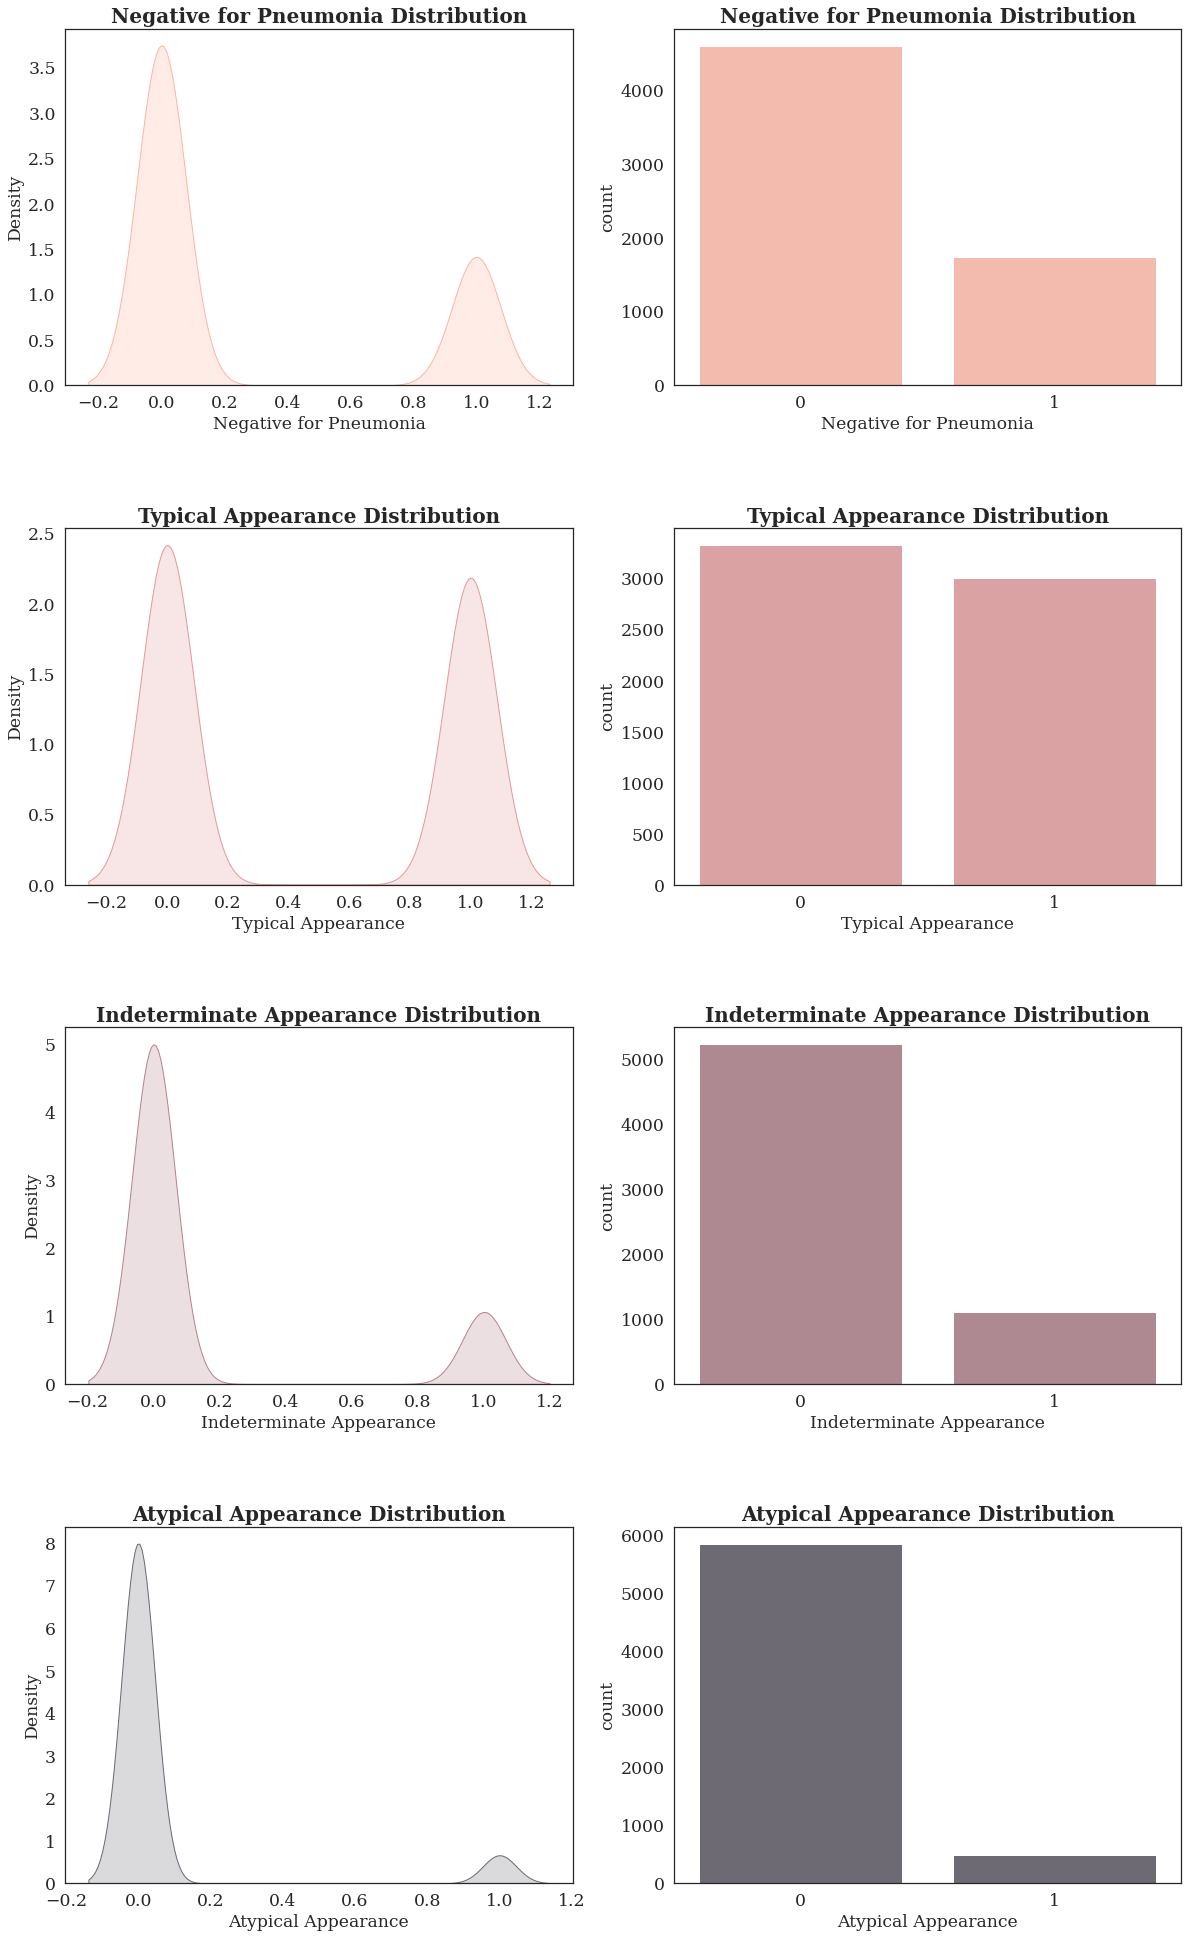

In [18]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 32),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

fig, ax = plt.subplots(4,2)
sns.kdeplot(train_df["Negative for Pneumonia"], shade=True,ax=ax[0,0],color="#ffb4a2")
ax[0,0].set_title("Negative for Pneumonia Distribution",font="Serif", fontsize=20,weight="bold")
sns.countplot(x = train_df["Negative for Pneumonia"], ax=ax[0,1],color="#ffb4a2")
ax[0,1].set_title("Negative for Pneumonia Distribution",font="Serif", fontsize=20,weight="bold")

sns.kdeplot(train_df["Typical Appearance"], shade=True,ax=ax[1,0],color="#e5989b")
ax[1,0].set_title("Typical Appearance Distribution",font="Serif", fontsize=20,weight="bold")
sns.countplot(x = train_df["Typical Appearance"], ax=ax[1,1],color="#e5989b")
ax[1,1].set_title("Typical Appearance Distribution",font="Serif", fontsize=20,weight="bold")

sns.kdeplot(train_df["Indeterminate Appearance"], shade=True,ax=ax[2,0],color="#b5838d")
ax[2,0].set_title("Indeterminate Appearance Distribution",font="Serif", fontsize=20,weight="bold")
sns.countplot(x = train_df["Indeterminate Appearance"], ax=ax[2,1],color="#b5838d")
ax[2,1].set_title("Indeterminate Appearance Distribution",font="Serif", fontsize=20,weight="bold")

sns.kdeplot(train_df["Atypical Appearance"], shade=True,ax=ax[3,0],color="#6d6875")
ax[3,0].set_title("Atypical Appearance Distribution",font="Serif", fontsize=20,weight="bold")
sns.countplot(x = train_df["Atypical Appearance"], ax=ax[3,1],color="#6d6875")
ax[3,1].set_title("Atypical Appearance Distribution",font="Serif", fontsize=20,weight="bold")

fig.subplots_adjust(wspace=0.2, hspace=0.4, top=0.93)
plt.show()

In [21]:
#====== Function to plot WandB bar chart ======
def plot_wb_bar(df,col1,col2): 
    run = wandb.init(project='siim-fisabio-rsna-covid-19-detection', job_type='image-visualization',name=col1,config = CONFIG)
    
    dt = [[label, val] for (label, val) in zip(df[col1], df[col2])]
    table = wandb.Table(data=dt, columns = [col1,col2])
    wandb.log({col1 : wandb.plot.bar(table, col1,col2,title=col1)})

    run.finish()
    
#====== Function to create a dataframe of value counts ======
def count_values(df,col):
    df = pd.DataFrame(df[col].value_counts().reset_index().values,columns=[col, "counts"])
    return df

plot_wb_bar(count_values(train_df,"Negative for Pneumonia"),"Negative for Pneumonia", 'counts')
plot_wb_bar(count_values(train_df,"Typical Appearance"),"Typical Appearance", 'counts')
plot_wb_bar(count_values(train_df,"Indeterminate Appearance"),"Indeterminate Appearance", 'counts')
plot_wb_bar(count_values(train_df,"Atypical Appearance"),"Atypical Appearance", 'counts')